In [1]:
from ctgomartini.api import MartiniTopFile
from ctgomartini.func import WriteItp
from function import *

def MBP_exp_energy_combine(energy1, energy2, beta, C1, C2):
    part1=np.exp(-beta*(energy1+C1))
    part2=np.exp(-beta*(energy2+C2))

    part=part1+part2
    energy=-np.log(part)/beta
    return energy

def MBP_exp_forces_combine(forces1, forces2, energy1, energy2, beta, C1, C2):
    part1=np.exp(-beta*(energy1+C1))
    part2=np.exp(-beta*(energy2+C2))

    part=part1+part2
    forces=part1/part*forces1+part2/part*forces2
    return forces

def MBP_ham_energy_combine(energy1, energy2, delta, C1, C2):
    dV=C2-C1
    part1=(energy1+energy2+dV)/2
    part2=(energy1-energy2-dV)/2

    energy=part1-np.sqrt(part2**2+delta**2)
    return energy

def MBP_ham_forces_combine(forces1, forces2, energy1, energy2, delta, C1, C2):
    dV=C2-C1
    alpha=(energy1-energy2-dV)/2
    C=1/2*(1-alpha/np.sqrt(alpha**2+delta**2))

    forces=C*forces1+(1-C)*forces2
    return forces

    
def GetMBPParameter(working_dir, topfile='system.top'):
    """
    get MBP Parameters
    """
    os.chdir(working_dir)
    top = MartiniTopFile(topfile)
    MBP_paramters = []
    for molecule_name, molecule_type in top.moleculeTypes.items():
        if 'multiple_basin' in molecule_type._topology:
            MBP_paramters.append(molecule_type._topology['multiple_basin'][0])
    return MBP_paramters


def Compare_energy(energy1, energy2, isPrint=True):
    energy1 = float(energy1)
    energy2 = float(energy2)

    relative_energy_error = abs(energy1 - energy2) * \
        2 / (abs(energy1)+abs(energy2))
    abs_energy_error = abs(energy1 - energy2)

    if isPrint:
        print('Energy Compare')
        print(f'Absolute error: {abs_energy_error:.2e}')
        print(f'Relative error: {relative_energy_error:.2e}')

    if relative_energy_error <= 1e-5 or abs_energy_error <= 1e-3:
        if isPrint:
            print("Energies match!")
        result = True
    else:
        if isPrint:
            print("Error: Energies do not match!")
        result = False
    
    return result, abs_energy_error, relative_energy_error
    
def Compare_forces(forces1, forces2, isPrint=True):
    average = 0.5*np.linalg.norm(forces1, axis=1) + 0.5*np.linalg.norm(forces2, axis=1)

    relative_force_error = np.linalg.norm(forces1 - forces2, axis=1) / average
    relative_force_error = np.nan_to_num(relative_force_error, nan=0)
    max_relative_force_error, max_relative_force_error_index = relative_force_error.max(
    ), relative_force_error.argmax()

    abs_force_error = np.linalg.norm(forces1 - forces2, axis=1)
    max_abs_force_error, max_abs_force_error_index = abs_force_error.max(
    ), abs_force_error.argmax()

    atol = 1e-5
    rtol = 1e-4
    # allclose = abs_force_error-(atol+rtol*average)
    allclose = abs_force_error-(atol+rtol*np.linalg.norm(forces2, axis=1)) # use gmx forces as the standard
    mask = np.linalg.norm(forces2, axis=1) != 0 # exclude the force == 0
    max_allclose = allclose[mask].max()
    max_allclose_index = np.where(allclose == max_allclose)[0][0]
    max_abs_force_error = abs_force_error[max_allclose_index]
    max_relative_force_error = relative_force_error[max_allclose_index]
    if isPrint:
        print('###Forces Compare###')
        print(f'Max absolute error: {max_abs_force_error:.2e}')
        print(f'Max relative error: {max_relative_force_error:.2e}')
        print(f'      Max allclose: {max_allclose:.2e}')

    if max_allclose <= 0:
        if isPrint:
            print("Forces match!")
        result = True
    else:
        if isPrint:
            print("Error: Forces do not match!")
        result = False 

    return result, max_abs_force_error, max_relative_force_error, max_allclose

In [2]:
def CalculateOMMEnergyForces(working_dir, strfile='ions.gro', epsilon_r=15):
    os.chdir(working_dir)
    strfile = strfile
    topfile = "system.top"

    simulation = OMM_setSimulation(strfile, topfile, epsilon_r=epsilon_r, temperature=310.15, double_precision=True)
    OMM_calStrfile(strfile, simulation, set_vsite=True)

    omm_energy=Load_energy(clean=True)
    omm_forces=Load_forces(clean=True)    
    return omm_energy, omm_forces

def CalculateGMXEnergyForces(working_dir, strfile='ions.gro', epsilon_r=15):
    os.chdir(working_dir)
    strfile = strfile
    topfile = "system.top"

    GMX_set(strfile=strfile,trjfile=strfile,topfile=topfile, indexfile=None, CreateMDP=True, double_precision=True)
    GMX_run()

    gmx_energy=Load_energy(clean=True)
    gmx_forces=Load_forces(clean=True)    
    return gmx_energy, gmx_forces

In [3]:
def SetMBPParameter(working_dir, topfile='system.top', MBP_parameters = [['True', 'exp', '2', '1/300', '-300', '0']]):
    """
    get MBP Parameters
    """
    os.chdir(working_dir)
    top = MartiniTopFile(topfile)
    MBP_paramters = []
    for molecule_name, molecule_type in top.moleculeTypes.items():
        if 'multiple_basin' in molecule_type._topology:
            molecule_type._topology['multiple_basin'] = MBP_parameters
            WriteItp(molecule_type)

In [4]:
def CompareResults_EXP(base_dir, strfile='ions.gro', epsilon_r=15, 
                   EXP_parameters = [['True', 'exp', '2', '1/300', '-300', '0']]):
    working_dir = os.path.join(base_dir, 'Open')
    energy_stateA, forces_stateA = CalculateGMXEnergyForces(working_dir, strfile, epsilon_r=epsilon_r)

    working_dir = os.path.join(base_dir, 'Closed')
    energy_stateB, forces_stateB = CalculateGMXEnergyForces(working_dir, strfile, epsilon_r=epsilon_r)

    working_dir = os.path.join(base_dir, 'EXP')
    SetMBPParameter(working_dir, topfile='system.top', MBP_parameters = EXP_parameters)
    energy_exp, forces_exp = CalculateOMMEnergyForces(working_dir, strfile, epsilon_r=epsilon_r)
    exp_param = GetMBPParameter(working_dir, topfile='system.top')[0]


    # Energy and forces comparison for Exponential mixing scheme
    print("Exponential mixing scheme for multiple baisn popential")
    print("Parameters: ",exp_param)
    energy_exp_cal = MBP_exp_energy_combine(energy_stateA[:,1], energy_stateB[:,1], beta=eval(exp_param[3]), C1=eval(exp_param[4]), C2=eval(exp_param[5]))
    forces_exp_cal = MBP_exp_forces_combine(forces_stateA[:,1:], forces_stateB[:,1:], energy_stateA[:,1], energy_stateB[:,1], beta=eval(exp_param[3]), C1=eval(exp_param[4]), C2=eval(exp_param[5]))

    result_energy, abs_energy_error, relative_energy_error =Compare_energy(energy_exp[:,1:], energy_exp_cal, isPrint=True)
    result_forces, max_abs_force_error, max_relative_force_error, max_allclose =Compare_forces(forces_exp[:,1:], forces_exp_cal, isPrint=True)
    
    if not (result_energy and result_forces):
        raise AssertionError("Energies or forces do not match for Exponential mixing scheme.")

    return [abs_energy_error, relative_energy_error, max_abs_force_error, max_relative_force_error, max_allclose]


In [5]:
def CompareResults_HAM(base_dir, strfile='ions.gro', epsilon_r=15, 
                   HAM_parameters = [['True', 'ham', '2', '300', '-300', '0']]):
    working_dir = os.path.join(base_dir, 'Open')
    energy_stateA, forces_stateA = CalculateGMXEnergyForces(working_dir, strfile, epsilon_r=epsilon_r)

    working_dir = os.path.join(base_dir, 'Closed')
    energy_stateB, forces_stateB = CalculateGMXEnergyForces(working_dir, strfile, epsilon_r=epsilon_r)


    working_dir = os.path.join(base_dir, 'HAM')
    SetMBPParameter(working_dir, topfile='system.top', MBP_parameters = HAM_parameters)
    energy_ham, forces_ham = CalculateOMMEnergyForces(working_dir, strfile, epsilon_r=epsilon_r)
    ham_param = GetMBPParameter(working_dir, topfile='system.top')[0]


    # Energy and forces comparison for Hamiltonian mixing scheme
    print("Hamiltonian mixing scheme for multiple baisn popential")
    print("Parameters: ",ham_param)
    energy_ham_cal = MBP_ham_energy_combine(energy_stateA[:,1], energy_stateB[:,1], delta=eval(ham_param[3]), C1=eval(ham_param[4]), C2=eval(ham_param[5]))
    forces_ham_cal = MBP_ham_forces_combine(forces_stateA[:,1:], forces_stateB[:,1:], energy_stateA[:,1], energy_stateB[:,1], delta=eval(ham_param[3]), C1=eval(ham_param[4]), C2=eval(ham_param[5]))

    result_energy, abs_energy_error, relative_energy_error = Compare_energy(energy_ham[:,1:], energy_ham_cal, isPrint=True)
    result_forces, max_abs_force_error, max_relative_force_error, max_allclose =Compare_forces(forces_ham[:,1:], forces_ham_cal, isPrint=True)
    if not (result_energy and result_forces):
        raise AssertionError("Energies or forces do not match for Hamiltonian mixing scheme.")
    
    return [abs_energy_error, relative_energy_error, max_abs_force_error, max_relative_force_error, max_allclose]

In [6]:
# base_dir = os.getcwd()
base_dir = "/home/ys/CommonUse/Martini/CTGoMartini/tests/data/MultipleBasinGoMartini_v2/GlnBP/"
print(base_dir)

import pandas as pd

/home/ys/CommonUse/Martini/CTGoMartini/tests/data/MultipleBasinGoMartini_v2/GlnBP/


In [7]:
EXP_parameters_list = [[['True', 'exp', '2', '1/300', '-300', '0']],
                        [['True', 'exp', '2', '1/500', '-300', '0']],
                        [['True', 'exp', '2', '1/300', '-600', '0']],
                        ]

for j, EXP_parameters in enumerate(EXP_parameters_list):
    data_list = []
    print(EXP_parameters)
    for i in range(0,10):
        strfile = os.path.join(base_dir,f'Strfiles/GlnBP_No{i}.gro')
        print(strfile)
        # EXP_parameters = [['True', 'exp', '2', '1/300', '-300', '0']]
        data = CompareResults_EXP(base_dir, strfile=strfile, epsilon_r = 15, EXP_parameters=EXP_parameters)  
        data_list.append(data)
        
    df = pd.DataFrame(data_list, 
                  columns=['abs_energy_error',
                            'relative_energy_error',
                            'max_abs_force_error',
                            'max_relative_force_error',
                            'max_allclose'])
    df.to_csv(os.path.join(base_dir, f'GlnBP_EXP_parameters{j}.csv'))

[['True', 'exp', '2', '1/300', '-300', '0']]
/home/ys/CommonUse/Martini/CTGoMartini/tests/data/MultipleBasinGoMartini_v2/GlnBP/Strfiles/GlnBP_No0.gro
GlnBP uses the multiple basin potential.
['True', 'exp', '2', '1/300', '-300', '0']
-1/beta * log(exp(-beta * (energy1 + C1)) + exp(-beta * (energy2 + C2)));
energy1 = state1_force1 + state1_force2 + state1_force3;
energy2 = state2_force1 + state2_force2 + state2_force3;
Exponential mixing scheme for multiple baisn popential
Parameters:  ['True', 'exp', '2', '1/300', '-300', '0']
Energy Compare
Absolute error: 3.71e-06
Relative error: 3.38e-11
Energies match!
###Forces Compare###
Max absolute error: 4.49e-06
Max relative error: 1.38e-06
      Max allclose: -3.30e-04
Forces match!
/home/ys/CommonUse/Martini/CTGoMartini/tests/data/MultipleBasinGoMartini_v2/GlnBP/Strfiles/GlnBP_No1.gro


/tmp/ipykernel_2480250/3613186070.py:78: RuntimeWarning: invalid value encountered in divide
  relative_force_error = np.linalg.norm(forces1 - forces2, axis=1) / average


GlnBP uses the multiple basin potential.
['True', 'exp', '2', '1/300', '-300', '0']
-1/beta * log(exp(-beta * (energy1 + C1)) + exp(-beta * (energy2 + C2)));
energy1 = state1_force1 + state1_force2 + state1_force3;
energy2 = state2_force1 + state2_force2 + state2_force3;
Exponential mixing scheme for multiple baisn popential
Parameters:  ['True', 'exp', '2', '1/300', '-300', '0']
Energy Compare
Absolute error: 3.33e-06
Relative error: 3.04e-11
Energies match!
###Forces Compare###
Max absolute error: 6.87e-06
Max relative error: 1.57e-06
      Max allclose: -4.41e-04
Forces match!
/home/ys/CommonUse/Martini/CTGoMartini/tests/data/MultipleBasinGoMartini_v2/GlnBP/Strfiles/GlnBP_No2.gro
GlnBP uses the multiple basin potential.
['True', 'exp', '2', '1/300', '-300', '0']
-1/beta * log(exp(-beta * (energy1 + C1)) + exp(-beta * (energy2 + C2)));
energy1 = state1_force1 + state1_force2 + state1_force3;
energy2 = state2_force1 + state2_force2 + state2_force3;
Exponential mixing scheme for multip

/tmp/ipykernel_2480250/3613186070.py:78: RuntimeWarning: invalid value encountered in divide
  relative_force_error = np.linalg.norm(forces1 - forces2, axis=1) / average


GlnBP uses the multiple basin potential.
['True', 'exp', '2', '1/500', '-300', '0']
-1/beta * log(exp(-beta * (energy1 + C1)) + exp(-beta * (energy2 + C2)));
energy1 = state1_force1 + state1_force2 + state1_force3;
energy2 = state2_force1 + state2_force2 + state2_force3;
Exponential mixing scheme for multiple baisn popential
Parameters:  ['True', 'exp', '2', '1/500', '-300', '0']
Energy Compare
Absolute error: 3.32e-06
Relative error: 3.03e-11
Energies match!
###Forces Compare###
Max absolute error: 6.87e-06
Max relative error: 1.57e-06
      Max allclose: -4.41e-04
Forces match!
/home/ys/CommonUse/Martini/CTGoMartini/tests/data/MultipleBasinGoMartini_v2/GlnBP/Strfiles/GlnBP_No2.gro
GlnBP uses the multiple basin potential.
['True', 'exp', '2', '1/500', '-300', '0']
-1/beta * log(exp(-beta * (energy1 + C1)) + exp(-beta * (energy2 + C2)));
energy1 = state1_force1 + state1_force2 + state1_force3;
energy2 = state2_force1 + state2_force2 + state2_force3;
Exponential mixing scheme for multip

/tmp/ipykernel_2480250/3613186070.py:78: RuntimeWarning: invalid value encountered in divide
  relative_force_error = np.linalg.norm(forces1 - forces2, axis=1) / average


GlnBP uses the multiple basin potential.
['True', 'exp', '2', '1/300', '-600', '0']
-1/beta * log(exp(-beta * (energy1 + C1)) + exp(-beta * (energy2 + C2)));
energy1 = state1_force1 + state1_force2 + state1_force3;
energy2 = state2_force1 + state2_force2 + state2_force3;
Exponential mixing scheme for multiple baisn popential
Parameters:  ['True', 'exp', '2', '1/300', '-600', '0']
Energy Compare
Absolute error: 3.38e-06
Relative error: 3.08e-11
Energies match!
###Forces Compare###
Max absolute error: 6.87e-06
Max relative error: 1.57e-06
      Max allclose: -4.41e-04
Forces match!
/home/ys/CommonUse/Martini/CTGoMartini/tests/data/MultipleBasinGoMartini_v2/GlnBP/Strfiles/GlnBP_No2.gro
GlnBP uses the multiple basin potential.
['True', 'exp', '2', '1/300', '-600', '0']
-1/beta * log(exp(-beta * (energy1 + C1)) + exp(-beta * (energy2 + C2)));
energy1 = state1_force1 + state1_force2 + state1_force3;
energy2 = state2_force1 + state2_force2 + state2_force3;
Exponential mixing scheme for multip

In [10]:
HAM_parameters_list = [[['True', 'ham', '2', '100', '-200', '0']],
                        [['True', 'ham', '2', '600', '-200', '0']],
                        [['True', 'ham', '2', '100', '-900', '0']],
                        ]

for j, HAM_parameters in enumerate(HAM_parameters_list):
    data_list = []
    print(HAM_parameters)
    for i in range(0,10):
        strfile = os.path.join(base_dir,f'Strfiles/GlnBP_No{i}.gro')
        print(strfile)
        data = CompareResults_HAM(base_dir, strfile=strfile, epsilon_r = 15, HAM_parameters=HAM_parameters)  
        data_list.append(data)
        
    df = pd.DataFrame(data_list, 
                  columns=['abs_energy_error',
                            'relative_energy_error',
                            'max_abs_force_error',
                            'max_relative_force_error',
                            'max_allclose'])
    df.to_csv(os.path.join(base_dir, f'GlnBP_HAM_parameters{j}.csv'))

[['True', 'ham', '2', '100', '-200', '0']]
/home/ys/CommonUse/Martini/CTGoMartini/tests/data/MultipleBasinGoMartini_v2/GlnBP/Strfiles/GlnBP_No0.gro
GlnBP uses the multiple basin potential.
['True', 'ham', '2', '100', '-200', '0']
(energy1+energy2+deltaV)/2 - sqrt(((energy1-energy2-deltaV)/2)^2+delta^2);deltaV=mbp_energy2-mbp_energy1;;
energy1 = state1_force1 + state1_force2 + state1_force3;
energy2 = state2_force1 + state2_force2 + state2_force3;
Hamiltonian mixing scheme for multiple baisn popential
Parameters:  ['True', 'ham', '2', '100', '-200', '0']
Energy Compare
Absolute error: 3.72e-06
Relative error: 3.40e-11
Energies match!
###Forces Compare###
Max absolute error: 4.49e-06
Max relative error: 1.38e-06
      Max allclose: -3.30e-04
Forces match!
/home/ys/CommonUse/Martini/CTGoMartini/tests/data/MultipleBasinGoMartini_v2/GlnBP/Strfiles/GlnBP_No1.gro


/tmp/ipykernel_2480250/3613186070.py:78: RuntimeWarning: invalid value encountered in divide
  relative_force_error = np.linalg.norm(forces1 - forces2, axis=1) / average


GlnBP uses the multiple basin potential.
['True', 'ham', '2', '100', '-200', '0']
(energy1+energy2+deltaV)/2 - sqrt(((energy1-energy2-deltaV)/2)^2+delta^2);deltaV=mbp_energy2-mbp_energy1;;
energy1 = state1_force1 + state1_force2 + state1_force3;
energy2 = state2_force1 + state2_force2 + state2_force3;
Hamiltonian mixing scheme for multiple baisn popential
Parameters:  ['True', 'ham', '2', '100', '-200', '0']
Energy Compare
Absolute error: 3.31e-06
Relative error: 3.03e-11
Energies match!
###Forces Compare###
Max absolute error: 6.87e-06
Max relative error: 1.57e-06
      Max allclose: -4.41e-04
Forces match!
/home/ys/CommonUse/Martini/CTGoMartini/tests/data/MultipleBasinGoMartini_v2/GlnBP/Strfiles/GlnBP_No2.gro
GlnBP uses the multiple basin potential.
['True', 'ham', '2', '100', '-200', '0']
(energy1+energy2+deltaV)/2 - sqrt(((energy1-energy2-deltaV)/2)^2+delta^2);deltaV=mbp_energy2-mbp_energy1;;
energy1 = state1_force1 + state1_force2 + state1_force3;
energy2 = state2_force1 + state2_

/tmp/ipykernel_2480250/3613186070.py:78: RuntimeWarning: invalid value encountered in divide
  relative_force_error = np.linalg.norm(forces1 - forces2, axis=1) / average


GlnBP uses the multiple basin potential.
['True', 'ham', '2', '600', '-200', '0']
(energy1+energy2+deltaV)/2 - sqrt(((energy1-energy2-deltaV)/2)^2+delta^2);deltaV=mbp_energy2-mbp_energy1;;
energy1 = state1_force1 + state1_force2 + state1_force3;
energy2 = state2_force1 + state2_force2 + state2_force3;
Hamiltonian mixing scheme for multiple baisn popential
Parameters:  ['True', 'ham', '2', '600', '-200', '0']
Energy Compare
Absolute error: 3.31e-06
Relative error: 3.02e-11
Energies match!
###Forces Compare###
Max absolute error: 6.87e-06
Max relative error: 1.57e-06
      Max allclose: -4.41e-04
Forces match!
/home/ys/CommonUse/Martini/CTGoMartini/tests/data/MultipleBasinGoMartini_v2/GlnBP/Strfiles/GlnBP_No2.gro
GlnBP uses the multiple basin potential.
['True', 'ham', '2', '600', '-200', '0']
(energy1+energy2+deltaV)/2 - sqrt(((energy1-energy2-deltaV)/2)^2+delta^2);deltaV=mbp_energy2-mbp_energy1;;
energy1 = state1_force1 + state1_force2 + state1_force3;
energy2 = state2_force1 + state2_

/tmp/ipykernel_2480250/3613186070.py:78: RuntimeWarning: invalid value encountered in divide
  relative_force_error = np.linalg.norm(forces1 - forces2, axis=1) / average


GlnBP uses the multiple basin potential.
['True', 'ham', '2', '100', '-900', '0']
(energy1+energy2+deltaV)/2 - sqrt(((energy1-energy2-deltaV)/2)^2+delta^2);deltaV=mbp_energy2-mbp_energy1;;
energy1 = state1_force1 + state1_force2 + state1_force3;
energy2 = state2_force1 + state2_force2 + state2_force3;
Hamiltonian mixing scheme for multiple baisn popential
Parameters:  ['True', 'ham', '2', '100', '-900', '0']
Energy Compare
Absolute error: 3.42e-06
Relative error: 3.14e-11
Energies match!
###Forces Compare###
Max absolute error: 6.87e-06
Max relative error: 1.57e-06
      Max allclose: -4.41e-04
Forces match!
/home/ys/CommonUse/Martini/CTGoMartini/tests/data/MultipleBasinGoMartini_v2/GlnBP/Strfiles/GlnBP_No2.gro
GlnBP uses the multiple basin potential.
['True', 'ham', '2', '100', '-900', '0']
(energy1+energy2+deltaV)/2 - sqrt(((energy1-energy2-deltaV)/2)^2+delta^2);deltaV=mbp_energy2-mbp_energy1;;
energy1 = state1_force1 + state1_force2 + state1_force3;
energy2 = state2_force1 + state2_

In [9]:
aaaa

NameError: name 'aaaa' is not defined

In [ ]:
for i in range()

<AxesSubplot:>

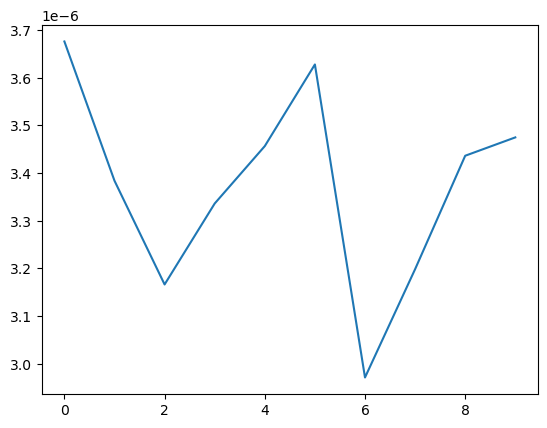

In [ ]:
df['abs_energy_error'].plot()

In [ ]:
CompareResults(base_dir, strfile=os.path.join(base_dir,'Strfiles/GlnBP_No0.gro'), epsilon_r = 15)  

GlnBP uses the multiple basin potential.
['True', 'exp', '2', '1/300', '-300', '0']
-1/beta * log(exp(-beta * (energy1 + C1)) + exp(-beta * (energy2 + C2)));
energy1 = state1_force1 + state1_force2 + state1_force3;
energy2 = state2_force1 + state2_force2 + state2_force3;
GlnBP uses the multiple basin potential.
['True', 'ham', '2', '300', '-300', '0']
(energy1+energy2+deltaV)/2 - sqrt(((energy1-energy2-deltaV)/2)^2+delta^2);deltaV=mbp_energy2-mbp_energy1;;
energy1 = state1_force1 + state1_force2 + state1_force3;
energy2 = state2_force1 + state2_force2 + state2_force3;
Exponential mixing scheme for multiple baisn popential
Parameters:  ['True', 'exp', '2', '1/300', '-300', '0']
Energy Compare
Absolute error: 3.71e-06
Relative error: 3.38e-11
Energies match!
###Forces Compare###
Max absolute error: 0.00e+00
Max relative error: 0.00e+00
      Max allclose: -1.00e-05
Forces match!
Hamiltonian mixing scheme for multiple baisn popential
Parameters:  ['True', 'ham', '2', '300', '-300', '0']
E

/tmp/ipykernel_1263271/381897684.py:109: RuntimeWarning: invalid value encountered in divide
  relative_force_error = np.linalg.norm(forces1 - forces2, axis=1) / average
